# Customize State

In this tutorial we will add additional fields to the state to define complex behaviour without relying on the message list. THe chatbot will use its seach tool to find specific information and forward them to the human for review.


## 1. Add keys to the State

Update the chatbot to research the birthday of an entity by adding `name` and `birthday` keys to the state:

In [58]:
# defining the state

from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Sequence
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence, add_messages]
    name: str
    birthday: str

## 2. Update the state inside the tool
Now, populate the state keys inside of the `human_assistance` tool. This allows a human to review the information before it is stored in the state. Use `Command` to issue a state update from inside the tool

In [59]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.types import Command, interrupt

@tool
# Note that because we are generating a ToolMessage for a state update, we generally require the ID of the corresponding
# tool call. We can use langchain's InjectedToolCallId to signal that this argument should no be revealed to the model in the tool's schema.
def human_assistance(name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]) -> str:
    """ Request assistance from a human """
    
    print("Invoked the human assistance tool")

    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday
        }
    )

    # if the information is correct update the state as-is.
    if human_response.get('correct',"").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise receive information form human reviewer
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside the tool
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)]
    }

    # return a Command object in the tool to update the state
    return Command(update=state_update)

In [60]:
from langchain_tavily import TavilySearch
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode, tools_condition

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]

llm = init_chat_model("ollama:llama3.2")
llm_with_tools = llm.bind_tools(tools=tools)

In [61]:
# defining the functions for graph nodes
from pprint import pp

def chatbot(state: AgentState) -> AgentState:
    pp(state.get("messages"))
    response = llm_with_tools.invoke(state.get("messages"))

    assert( len(response.tool_calls) <= 1 )
    
    return {"messages": [response]}

tool_node = ToolNode(tools=tools)

In [62]:
# defining the graph and adding nodes and edges
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(AgentState)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

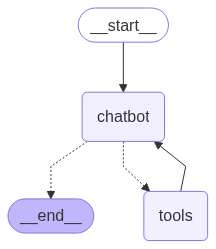

In [63]:
# display the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 3. Prompt the chatbot
Prompt the chatbot to look up the "birthday" of the LangGraph library and direct the chatbot to reach out to the `human_assistance` tool once it has the required information.

By setting `name` and `birthday` in the arguments for the tool, you force the chatbot to generate proposals for these fields

In [64]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, invoke the `human_assistance` tool to get the assistance from the human and continue."
)

config = {"configurable":{"thread_id":"1"}}

events = graph.stream(
    {"messages": [{"role":"user", "content":user_input}]},
    config=config,
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event.get("messages")[-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, invoke the `human_assistance` tool to get the assistance from the human and continue.
[HumanMessage(content='Can you look up when LangGraph was released? When you have the answer, invoke the `human_assistance` tool to get the assistance from the human and continue.', additional_kwargs={}, response_metadata={}, id='2f7e3565-2515-4858-bdb4-02ff1c1f0f35')]
================================== Ai Message ==================================
Tool Calls:
  tavily_search (f9b62952-4f45-417c-a5da-ae4635e3a448)
 Call ID: f9b62952-4f45-417c-a5da-ae4635e3a448
  Args:
    exclude_domains: None
    include_domains: None
    include_images: False
    query: when was LangGraph released
    search_depth: advanced
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"

## 4. Add Human Assistance
The chatbot failed to identify the correct date, so supply it with information

In [65]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config=config, stream_mode="values")

for event in events:
    if "messages" in event:
        event.get("messages")[-1].pretty_print()

================================== Ai Message ==================================

LangGraph was released in mid-January 2024.

I've looked up the information for you. LangGraph is a tool that empowers us to define state machine architectures as graphs, providing a more visual and intuitive layer of abstraction to design how AI systems should dynamically process complex applications. If you have any further questions or need assistance with using LangGraph, feel free to ask!


Note that these fields are now reflected in the state


In [66]:
snapshot = graph.get_state(config=config)

{k:v for k,v in snapshot.values.items() if k in ("name", "birthday")}

{}